### https://www.kaggle.com/code/manishasingh853/time-series-forecasting-with-machine-learning 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

In [5]:
df = pd.read_csv('data/PJME_hourly.csv')

In [6]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [7]:
df = df.set_index('Datetime')

In [8]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [9]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.metrics import mean_squared_error

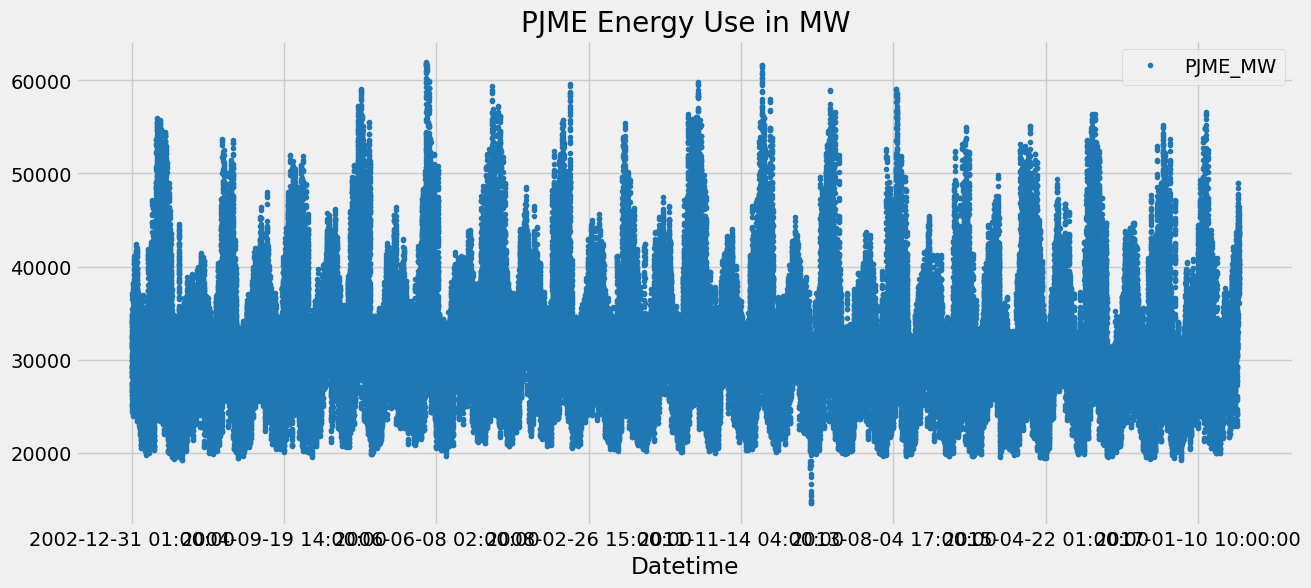

In [10]:
df.plot(style='.',
        figsize=(14,6),
        color=color_pal[0],
        title = 'PJME Energy Use in MW')
plt.show()

In [11]:
df.index.max(), df.index.min()

('2018-08-03 00:00:00', '2002-01-01 01:00:00')

In [13]:
df.shape

(145366, 1)

In [14]:
train_size = int(df.shape[0] * 0.8)
train_size

116292

In [17]:
df.iloc[:train_size].tail()

,PJME_MW
Datetime,
2015-09-24 08:00:00,27884.0
2015-09-24 09:00:00,28777.0
2015-09-24 10:00:00,29610.0
2015-09-24 11:00:00,30504.0
2015-09-24 12:00:00,31265.0


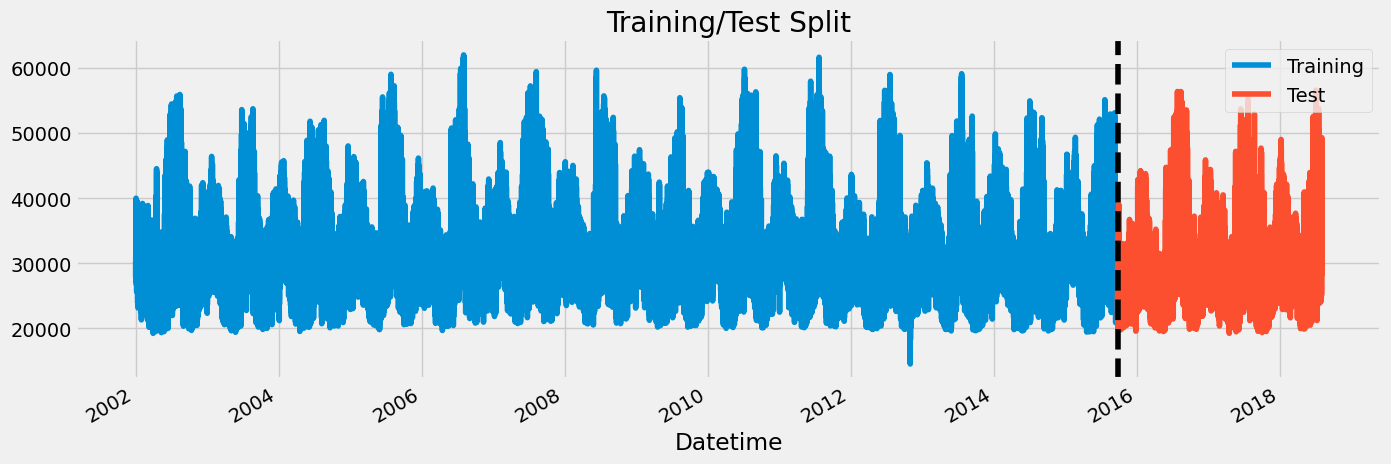

In [27]:

df.index = pd.to_datetime(df.index)
# train = df[:train_size]
# test = df[train_size:]
train = df.loc[df.index < '09-24-2015']
test = df.loc[df.index >= '09-24-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax = ax, label = 'Training', title = 'Training/Test Split')
test.plot(ax = ax, label = 'Test')
ax.axvline('09-24-2015', color = 'black', ls = '--')
ax.legend(['Training', 'Test'])
plt.show()

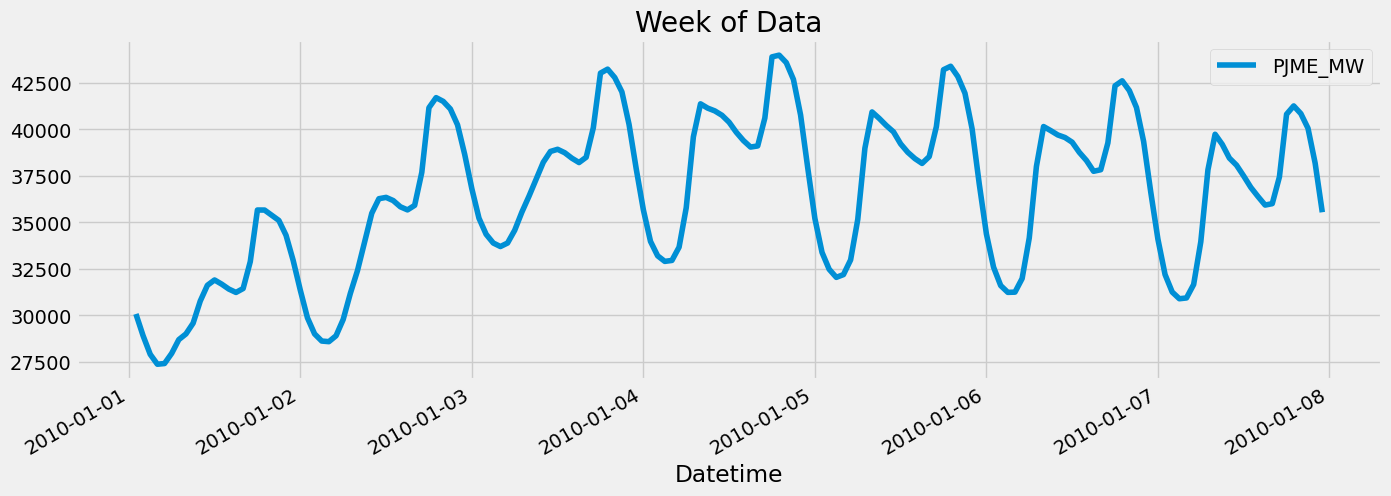

In [28]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
.plot(figsize=(15,5), title="Week of Data")
plt.show()

In [29]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [30]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


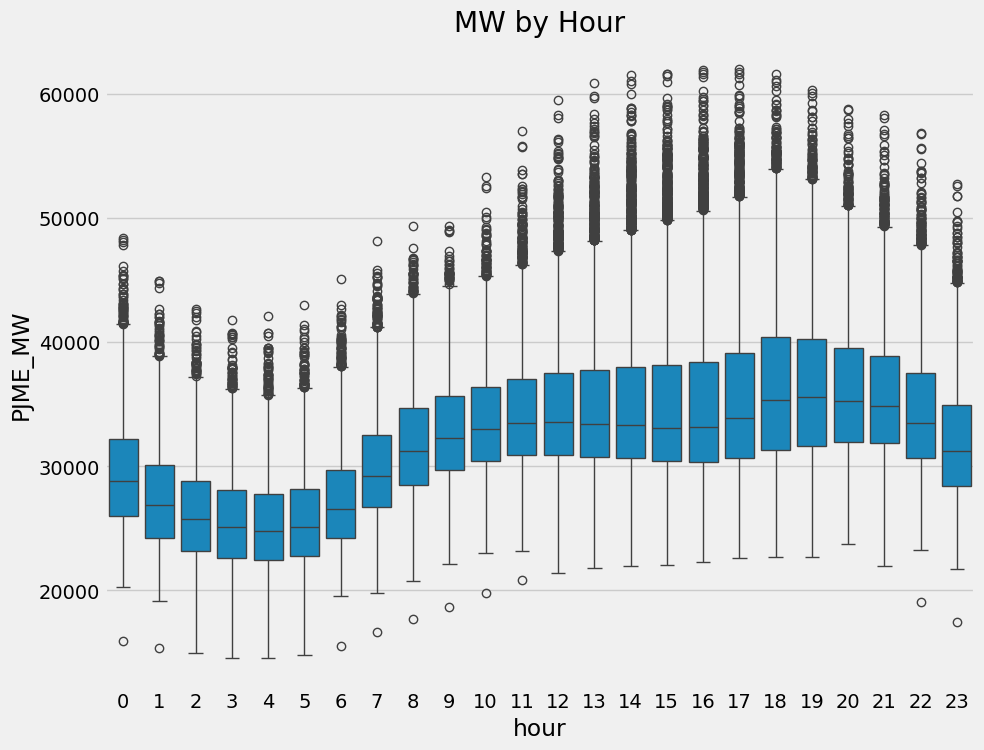

In [31]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data = df, x = 'hour', y = 'PJME_MW')
ax.set_title('MW by Hour')
plt.show()

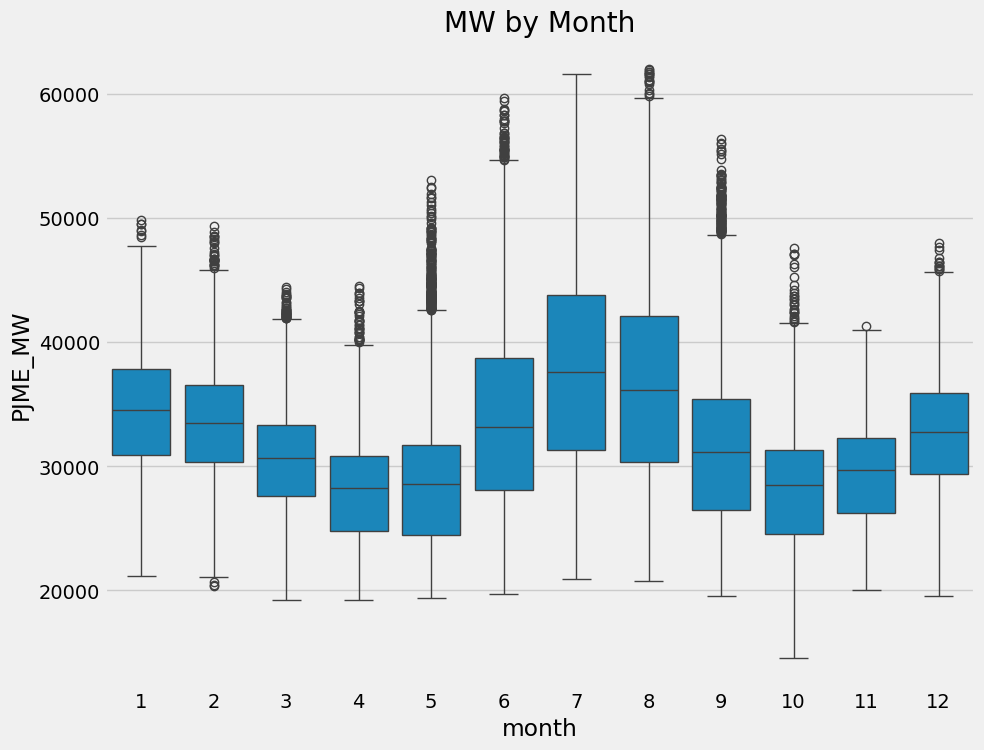

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y = 'PJME_MW')
ax.set_title('MW by Month')
plt.show()

In [35]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]



In [47]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32656.61236	validation_1-rmse:31151.80126


c:\Users\haode\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [11:31:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12606.39059	validation_1-rmse:11287.58537
[200]	validation_0-rmse:5858.54318	validation_1-rmse:5045.89936
[300]	validation_0-rmse:3955.43667	validation_1-rmse:3868.36323
[400]	validation_0-rmse:3485.87898	validation_1-rmse:3810.40816
[438]	validation_0-rmse:3410.35213	validation_1-rmse:3810.56286


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [48]:
# reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
#                          n_estimators = 1000,
#                          early_stopping_rounds = 50,
#                          objective = 'reg:squarederror',
#                          max_depth = 3,
#                          learning_rate = 0.01)

# reg.fit(X_train,y_train,
#         eval_set = [(X_train,y_train), (X_test,y_test)],
#         verbose = 100)

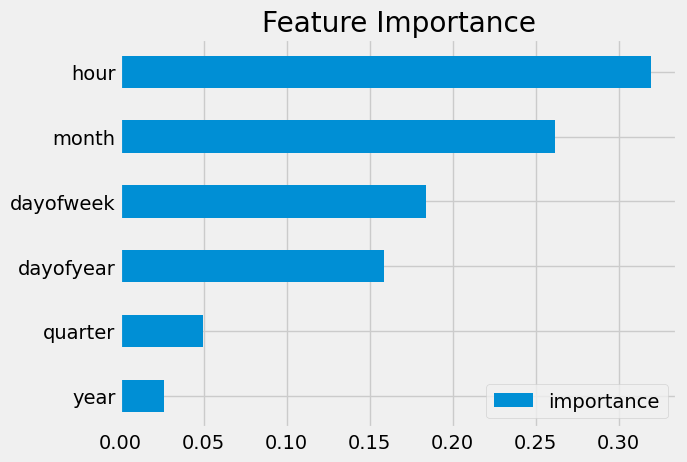

In [49]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

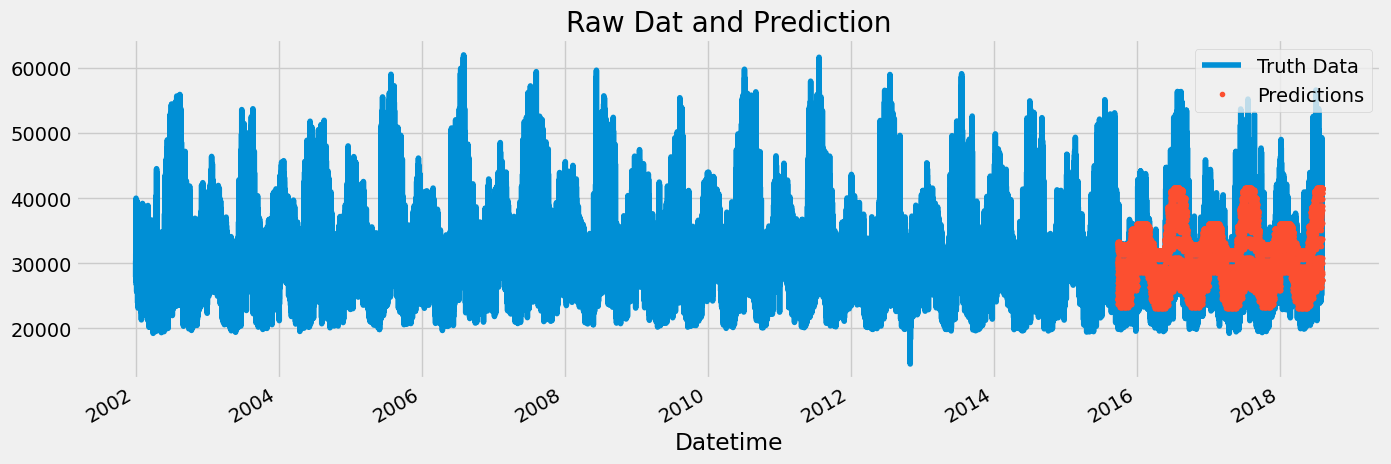

In [50]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

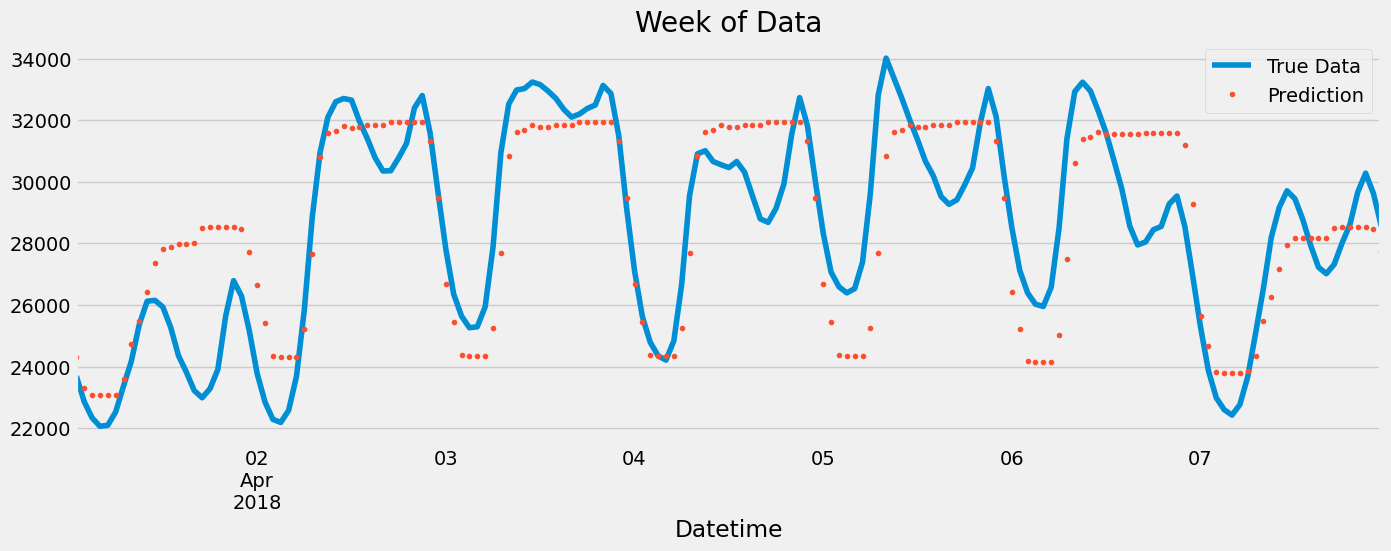

In [51]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')] \
['PJME_MW'] \
.plot(figsize=(15,5), title = 'Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')] \
['prediction'] \
.plot(style='.')
plt.legend(['True Data', 'Prediction'])
plt.show()

In [56]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'{score:0.2f}')

3807.76


In [57]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date

test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12304.929281
2016-08-14    11934.429036
2018-01-06    11676.321696
2016-09-10    11029.362956
2018-01-07    10641.762370
2016-09-09    10245.691081
2018-01-05    10167.434733
2016-08-12     9969.649821
2018-07-03     9547.769124
2018-07-02     9525.832438
Name: error, dtype: float64

In [59]:
#Accuracy = 1 - (Total Abs error)/(Total Target value)

abs_error = test['error'].sum()
actual = test[TARGET].sum()

accuracy = (1-abs_error/actual)*100
print(f'{accuracy:.2f}%')

90.21%


#### Arima model

In [61]:
ts = df[['PJME_MW']]

ts_train = train[['PJME_MW']]
ts_test = test[['PJME_MW']]

In [62]:
warnings.filterwarnings('ignore')

arima_model = SARIMAX(endog=ts_train)
fitted_model = arima_model.fit()

In [63]:
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:                PJME_MW   No. Observations:               120309
Model:               SARIMAX(1, 0, 0)   Log Likelihood            -1057851.649
Date:                Sun, 12 Jan 2025   AIC                        2115707.298
Time:                        12:14:16   BIC                        2115726.694
Sample:                             0   HQIC                       2115713.136
                             - 120309                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9988      0.000   7325.568      0.000       0.999       0.999
sigma2       2.54e+06   6.77e-13   3.75e+18      0.000    2.54e+06    2.54e+06
Ljung-Box (L1) (Q):               61362.92   Jarque-

In [64]:
n_forecast = ts_test.shape[0]
forecast = fitted_model.get_forecast(steps = n_forecast)
forecast_values = forecast.predicted_mean

ts_test['Prediction'] = list(forecast_values)

In [66]:
ts = ts.merge(ts_test[['Prediction']], how = 'left', left_index = True, right_index=True)
ts['Prediction'] = ts.Prediction.astype('float64')

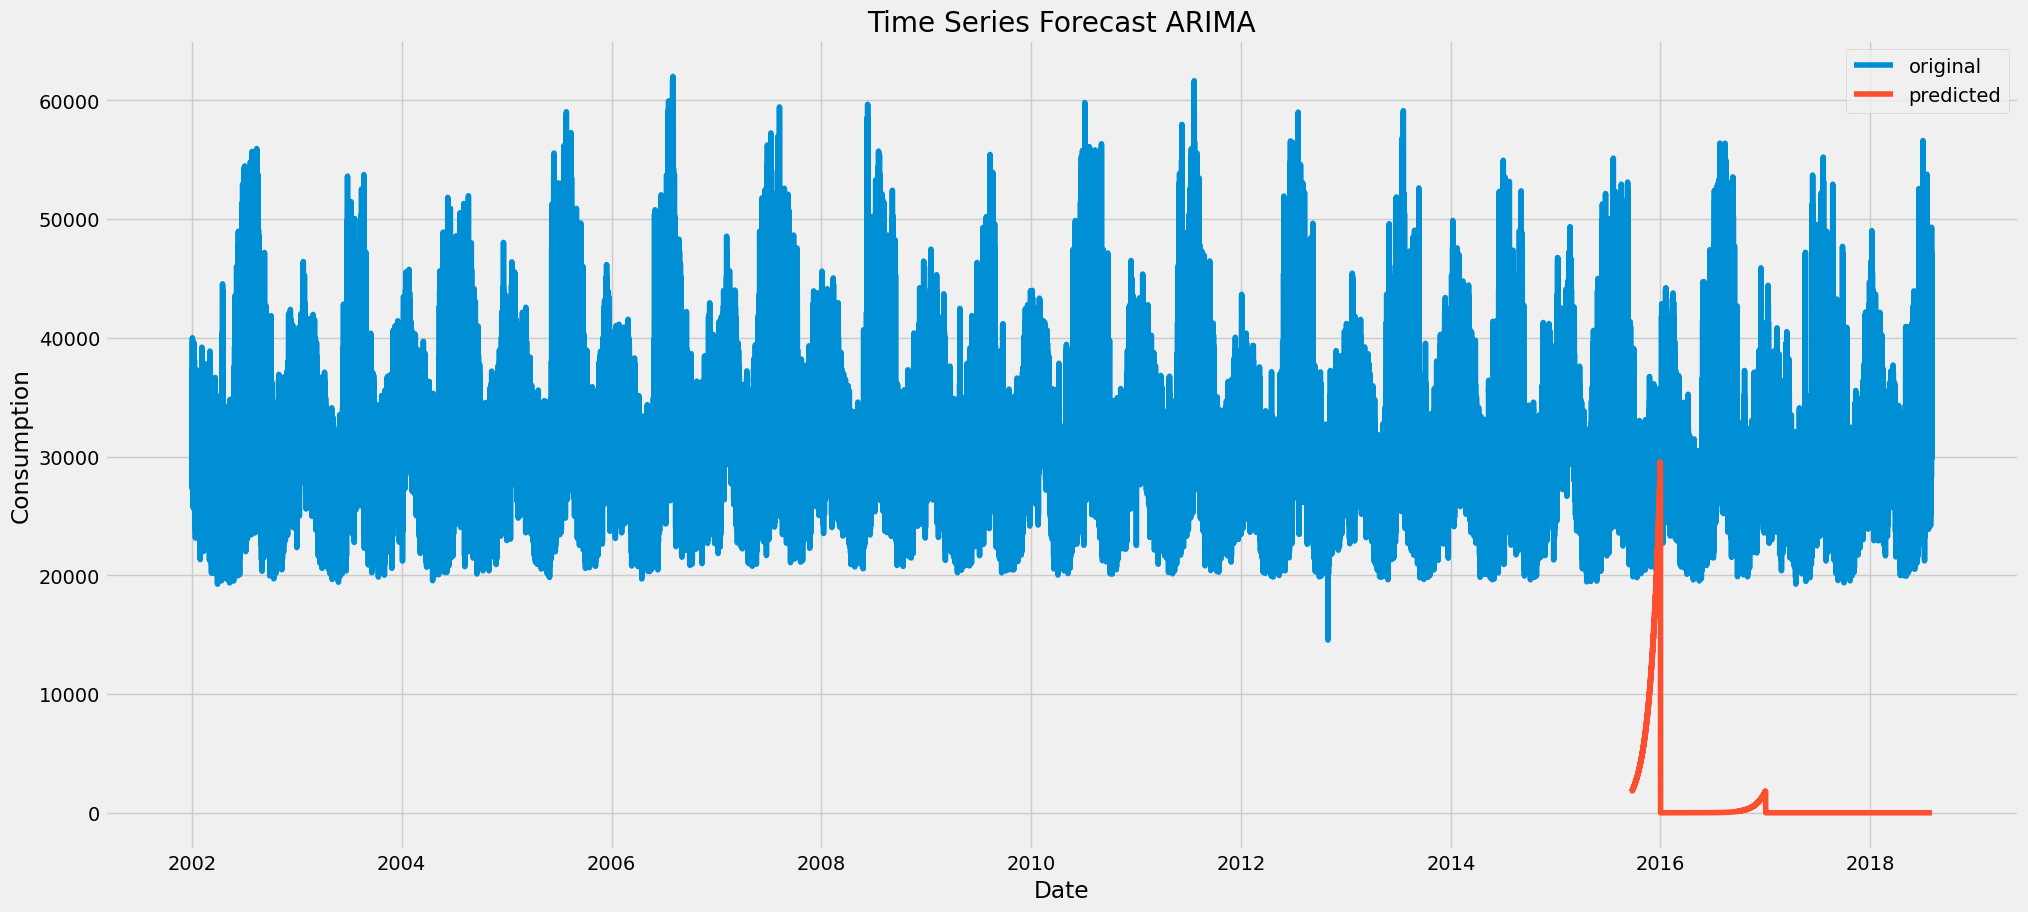

In [68]:
plt.figure(figsize=(22,10))
plt.plot(ts.PJME_MW, label='original')
plt.plot(ts.Prediction, label='predicted')

plt.title('Time Series Forecast ARIMA')
plt.xlabel('Date')
plt.ylabel('Consumption')

plt.legend()
plt.show()

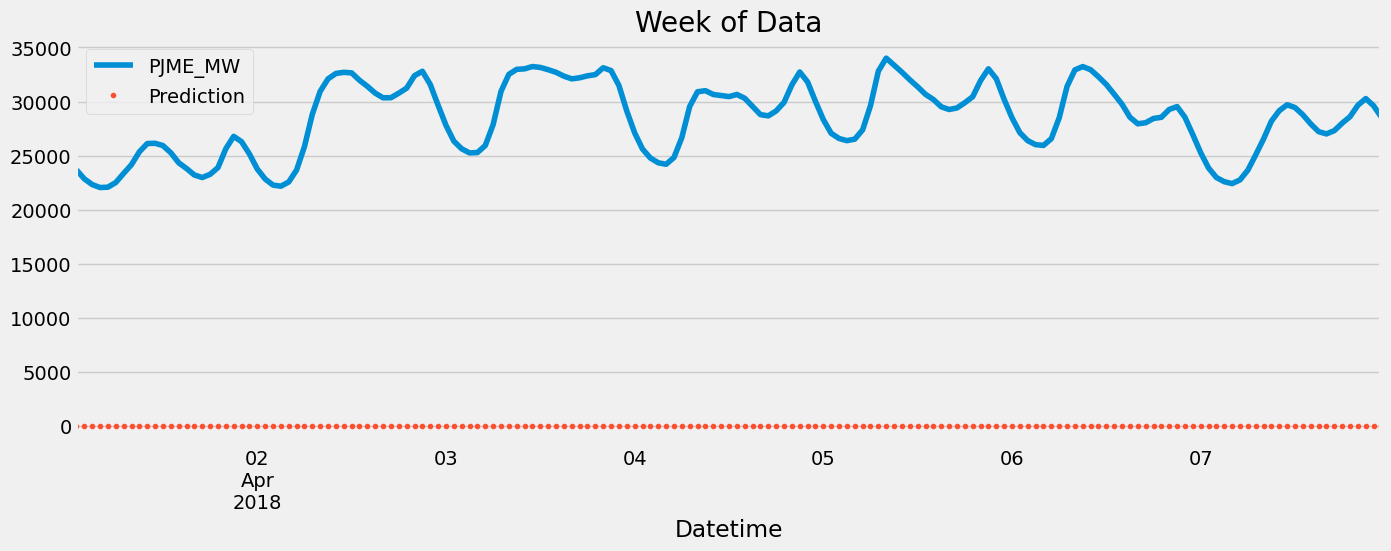

In [70]:
ax = ts.loc[(ts.index > '04-01-2018') & (ts.index < '04-08-2018')] \
['PJME_MW'] \
.plot(figsize=(15,5), title="Week of Data")
ts.loc[(ts.index > '04-01-2018') & (ts.index < '04-08-2018')] \
['Prediction'] \
.plot(style='.')
plt.legend()
plt.show()

In [72]:
from statsmodels.tsa.statespace.structural import UnobservedComponents as UCM

In [73]:
ucm_model = UCM(endog=ts_train, level=True, trend = True,
                irregular=False,
                seasonal=7)
ucm_model = ucm_model.fit(method='powell', disp=False, cov_type='robust',
                          maxiter=1000)

In [74]:
n_forecast = ts_test.shape[0]
ucm_prediction = list(ucm_model.forecast(steps = n_forecast))

In [75]:
ts_test['UCM_Prediction'] = ucm_prediction
ts = ts.merge(ts_test[['UCM_Prediction']], how = 'left', left_index=True, right_index=True)

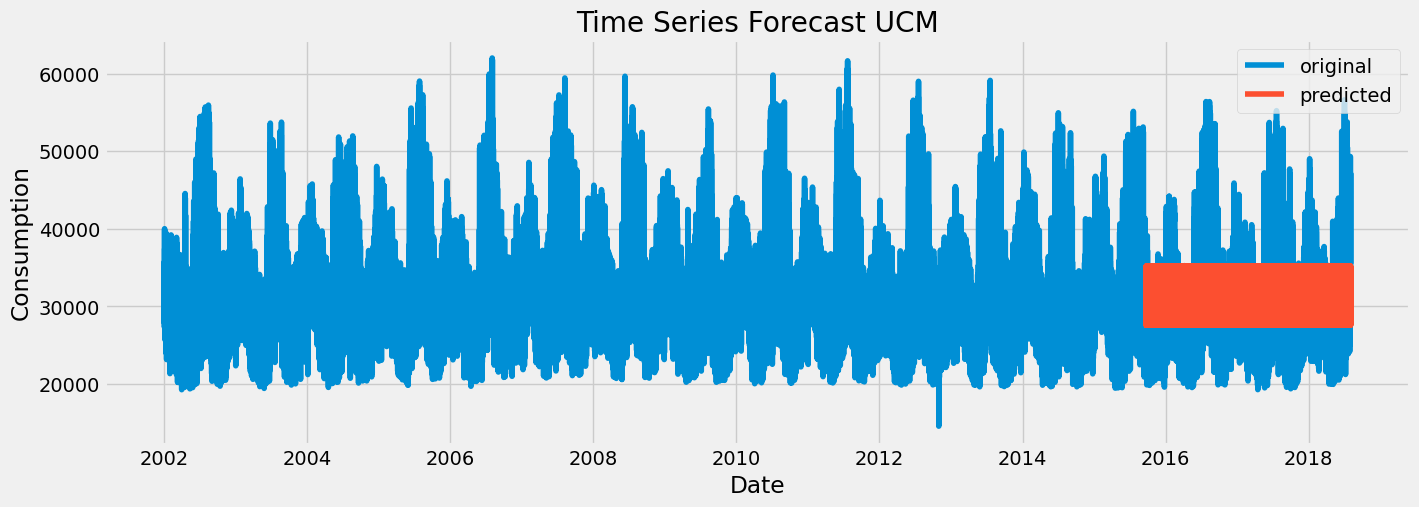

In [76]:
plt.figure(figsize=(15,5))
plt.plot(ts.PJME_MW, label = 'original')
plt.plot(ts.UCM_Prediction, label = 'predicted')

plt.title('Time Series Forecast UCM')
plt.xlabel('Date')
plt.ylabel('Consumption')

plt.legend()
plt.show()

In [77]:
ts_test['error'] = np.abs(ts_test[TARGET] - ts_test['Prediction'])
ts_test['date'] = ts_test.index.date

ts_test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-12    45690.003519
2018-07-03    45258.041666
2018-07-02    45218.124999
2016-08-11    45191.713117
2016-08-13    45150.141634
2017-07-20    44770.499364
2016-07-25    44419.799490
2016-08-14    44390.626685
2018-01-05    44197.791667
2016-08-15    43901.124541
Name: error, dtype: float64